In [2]:
!pip install mlxtend

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### Visualisierungen & Aufbereitung

In [3]:
df=pd.read_csv('ames.csv')
#ab 1000 rund testdaten --> allles(33%)

In [4]:
df["Sale_Price"].describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: Sale_Price, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

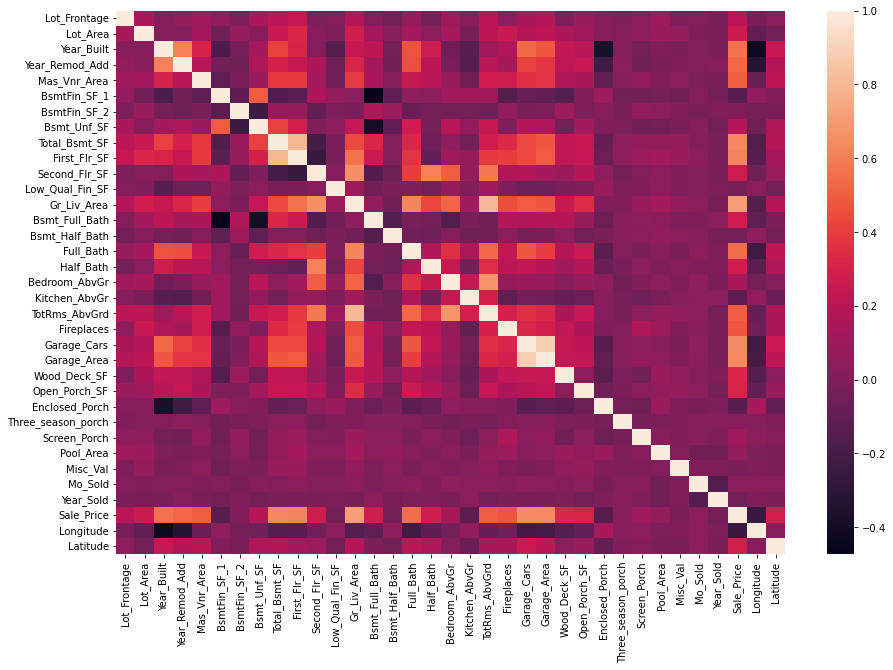

In [5]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr())
plt.show

Aus der Grafik ist erkennbar, dass folgende Features untereinander stark korrelieren:
- Total_Bsmt_SF und First_Flr_SF
- Garage_Cars und Garage_Area (je mehr Platz in der Garage desto mehr Autos passen auch rein)
- Gr_Live_Area und TotRms_AbvGrd (je mehr Platz, desto mehr Räume)

Deswegen nehmen wir für das Trainieren nur eine der jeweiligen Variablen. Die mit der höheren Korrelation mit Sale-Price.

In [6]:
df_top = df.drop(["Garage_Area", "First_Flr_SF", "TotRms_AbvGrd"], axis=1)
df_zwischen = pd.DataFrame(df_top.corr()["Sale_Price"].sort_values(ascending=False)).reset_index()
df_zwischen

,index,Sale_Price
0,Sale_Price,1.000000
1,Gr_Liv_Area,0.706780
2,Garage_Cars,0.647562
3,Total_Bsmt_SF,0.632529
4,Year_Built,0.558426
5,Full_Bath,0.545604
6,Year_Remod_Add,0.532974
7,Mas_Vnr_Area,0.502196
8,Fireplaces,0.474558
9,Wood_Deck_SF,0.327143


In [7]:
df_zwischen[df_zwischen["Sale_Price"] > 0.5]["index"].to_list()

['Sale_Price',
 'Gr_Liv_Area',
 'Garage_Cars',
 'Total_Bsmt_SF',
 'Year_Built',
 'Full_Bath',
 'Year_Remod_Add',
 'Mas_Vnr_Area']

In [8]:
df_top = df_top[df_zwischen[df_zwischen["Sale_Price"] > 0.5]["index"].to_list()]

In [9]:
df_top

,Sale_Price,Gr_Liv_Area,Garage_Cars,Total_Bsmt_SF,Year_Built,Full_Bath,Year_Remod_Add,Mas_Vnr_Area
0,215000,1656,2,1080,1960,1,1960,112
1,105000,896,1,882,1961,1,1961,0
2,172000,1329,1,1329,1958,1,1958,108
3,244000,2110,2,2110,1968,2,1968,0
4,189900,1629,2,928,1997,2,1998,0
...,...,...,...,...,...,...,...,...
2925,142500,1003,2,1003,1984,1,1984,0
2926,131000,902,2,864,1983,1,1983,0
2927,132000,970,0,912,1992,1,1992,0
2928,170000,1389,2,1389,1974,1,1975,0


In [10]:
df.dtypes.value_counts()

object     46
int64      33
float64     2
dtype: int64

In [11]:
df_top.dtypes.value_counts()

int64    8
dtype: int64

In [12]:
df.select_dtypes(include="float64")

,Longitude,Latitude
0,-93.619754,42.054035
1,-93.619756,42.053014
2,-93.619387,42.052659
3,-93.617320,42.051245
4,-93.638933,42.060899
...,...,...
2925,-93.604776,41.988964
2926,-93.602680,41.988314
2927,-93.606847,41.986510
2928,-93.600190,41.990921


In [13]:
X_all = df.drop(columns = ['Sale_Price'],axis=1)
y_all = df['Sale_Price']
X_all.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,5,2010,WD,Normal,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,6,2010,WD,Normal,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Pool,No_Fence,None,0,4,2010,WD,Normal,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Pool,Minimum_Privacy,None,0,3,2010,WD,Normal,-93.638933,42.060899


In [14]:
X_top = df_top.drop(columns = ['Sale_Price'],axis=1)
y_top = df_top['Sale_Price']
X_top.head()

,Gr_Liv_Area,Garage_Cars,Total_Bsmt_SF,Year_Built,Full_Bath,Year_Remod_Add,Mas_Vnr_Area
0,1656,2,1080,1960,1,1960,112
1,896,1,882,1961,1,1961,0
2,1329,1,1329,1958,1,1958,108
3,2110,2,2110,1968,2,1968,0
4,1629,2,928,1997,2,1998,0


In [15]:
def encode(X, has_objects=True):
    scaler = MinMaxScaler()
    if has_objects:
        # Transform string values to numbers
        object_df = X.select_dtypes(include="object")
        object_df = object_df.apply(LabelEncoder().fit_transform)

        # Select numeric values of data
        numerics = X.select_dtypes(include=["int64", "float64"])

        # Merge numerics and objects
        data = numerics.merge(object_df, left_index=True, right_index=True)
        return pd.DataFrame(scaler.fit_transform(data), columns=data.columns.to_list())
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns.to_list())

In [16]:
df_all = encode(X_all)
df_top = encode(X_top, has_objects=False)

In [17]:
df_all.dtypes.value_counts()

float64    80
dtype: int64

## Durchführung der Pipline einer Regression inklusive Kreuzvalidierung 

In [21]:
random_seed=42
test_size=0.3

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_all[:2001], y_all[:2001], random_state=random_seed, test_size=test_size)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(df_top[:2001], y_top[:2001], random_state=random_seed, test_size=test_size)

In [22]:
def validation(models, labels, X, y, cv=5):
    print('5-fold cross validation scores:\n')
    data=[]
    for clf, label in zip(models, labels):
        scores = cross_val_score(clf, X, y, cv=cv)
        data.append([scores.mean(),scores.std(),label])
    return pd.DataFrame(data,columns=['mean_score','std','label'])

In [23]:
# Initialize Models
svr = SVR(kernel='linear')
lasso = Lasso()
rf = RandomForestRegressor(n_estimators=5, random_state=random_seed)
stack = StackingCVRegressor(regressors=(svr, lasso, rf), meta_regressor=lasso, random_state=random_seed)

models = [svr, lasso, rf, stack]
labels = ['SVM', 'Lasso', 'Random Forest', 'StackingCVRegressor']

# Run cross-validation
overview_all = validation(models, labels, X_train_all, y_train_all, cv=5)
overview_top = validation(models, labels, X_train_top, y_train_top, cv=5)

5-fold cross validation scores:



c:\Users\Win10\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8013471721.410461, tolerance: 516929251.4372125
  positive)
c:\Users\Win10\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7435326448.57373, tolerance: 556135086.3793995
  positive)
c:\Users\Win10\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 660587795.8502197, tolerance: 532805444.0773532
  positive)
c:\Users\Win10\anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not conve

5-fold cross validation scores:



In [24]:
overview_all

,mean_score,std,label
0,-0.050191,0.021314,SVM
1,0.592116,0.399676,Lasso
2,0.844753,0.046217,Random Forest
3,0.778857,0.123152,StackingCVRegressor


In [25]:
overview_top

,mean_score,std,label
0,-0.059601,0.021799,SVM
1,0.738431,0.134725,Lasso
2,0.792183,0.045150,Random Forest
3,0.791277,0.078536,StackingCVRegressor
